✅ PyTorch available for LSTM modeling
📈 Financial Forecasting Pipeline Started (DEBUGGED)
🚀 Starting Financial Forecasting Pipeline...
📊 Downloading 3y of data for 4 symbols...
✅ AAPL: 753 trading days
✅ MSFT: 753 trading days
✅ GOOGL: 753 trading days
✅ TSLA: 753 trading days
⚠️ Missing columns: ['Adj Close']
📊 Available columns: ['Close', 'High', 'Low', 'Open', 'Volume']

🎯 Using AAPL as primary example
📅 Date range: 2022-08-09 to 2025-08-08
📊 Data shape: (753, 5)
📊 Columns: ['Close', 'High', 'Low', 'Open', 'Volume']
🔧 Creating features for AAPL...
✅ Features created. Shape: (753, 49) -> (704, 49)
📊 Removed 49 rows with NaN values

📈 Generated 44 new features:
['Returns', 'Log_Returns', 'High_Low_Ratio', 'Close_Open_Ratio', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20'] ...


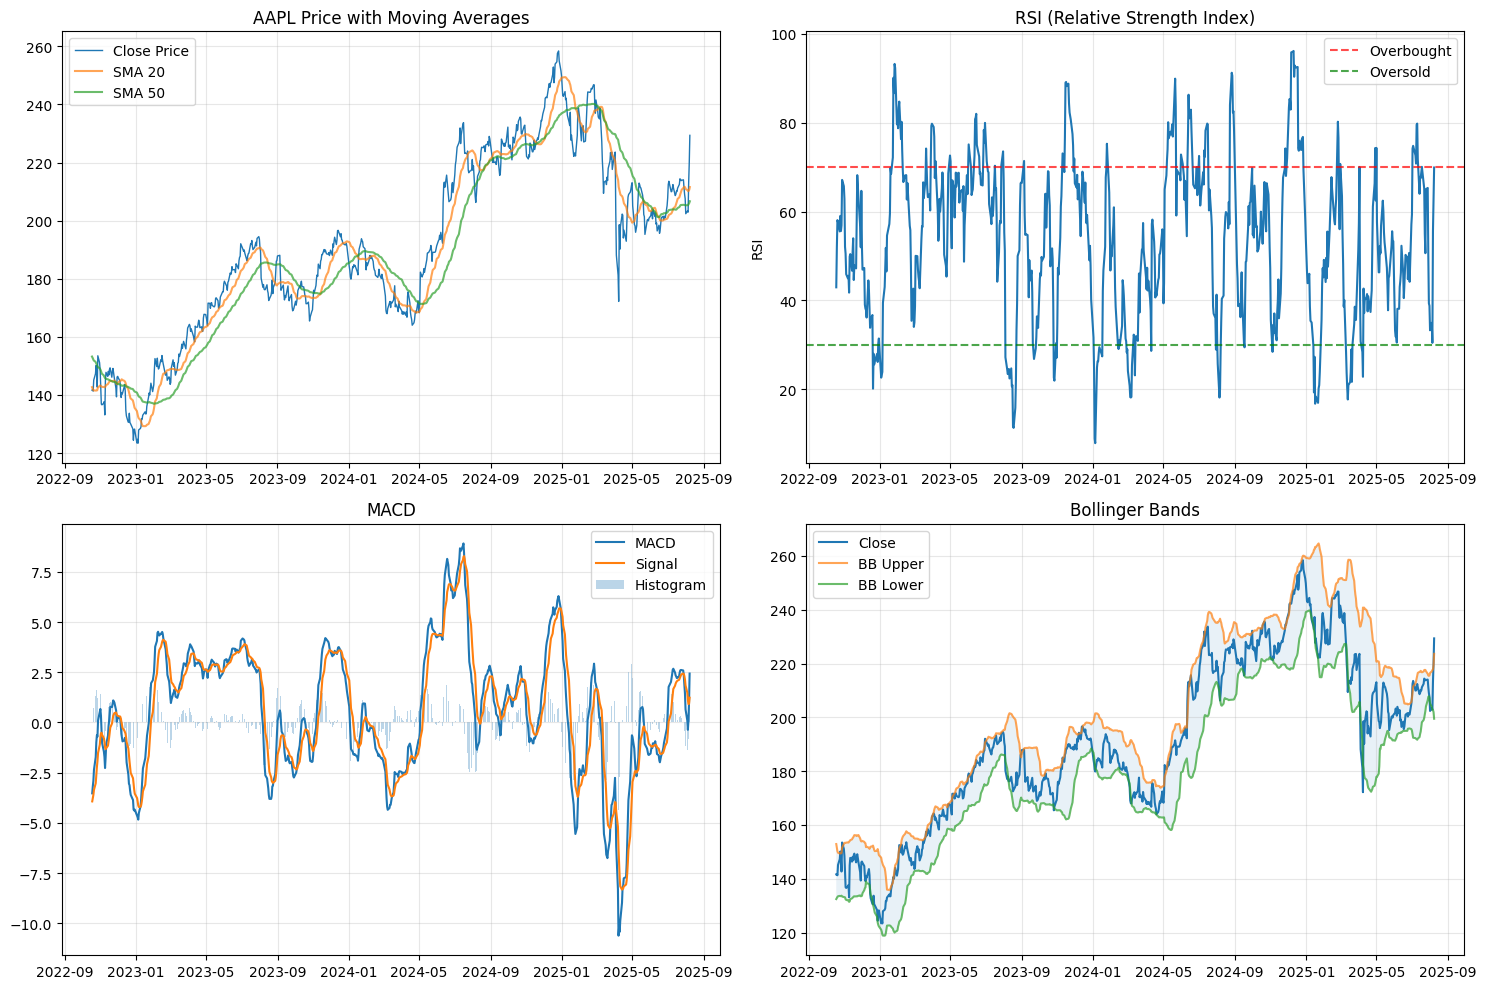

🔄 Preparing data for ML models...
🔧 ML Data prepared:
   - Features: 44
   - Training samples: 563
   - Test samples: 141
📊 Training set: (563, 44)
📊 Test set: (141, 44)
📊 Features: 44

🤖 Training ML models...
Training Linear Regression... ✅ Test R²: 1.0000, MAE: 0.05
Training Random Forest... ✅ Test R²: 0.7472, MAE: 5.92
Training Gradient Boosting... ✅ Test R²: 0.8682, MAE: 4.12

📊 Model Performance Summary:
                   Train R²  Test R²  Train MAE  Test MAE  Train RMSE  \
Linear Regression    1.0000   1.0000     0.0272    0.0453      0.0359   
Random Forest        0.9995   0.7472     0.4589    5.9175      0.6877   
Gradient Boosting    0.9998   0.8682     0.3290    4.1221      0.4040   

                   Test RMSE  
Linear Regression     0.0600  
Random Forest         7.6236  
Gradient Boosting     5.5039  
🔄 Preparing LSTM data...
📊 LSTM Training sequences: torch.Size([515, 60, 1])
📊 LSTM Test sequences: torch.Size([129, 60, 1])

🧠 Training LSTM model...
Epoch [10/50], Loss

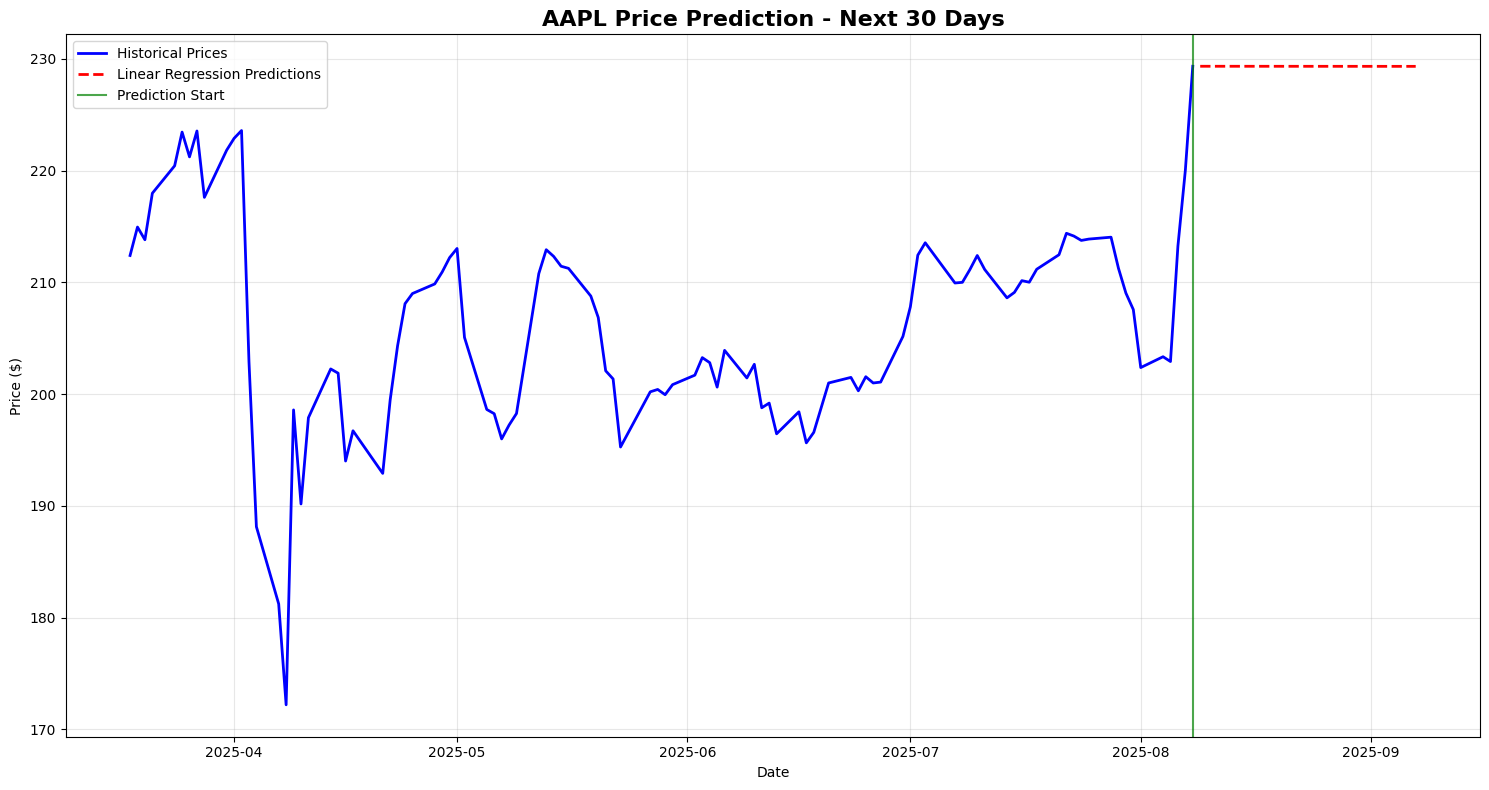


📋 Forecasting Summary for AAPL:
📊 Best performing model: Linear Regression
📈 Test R²: 1.0000
📊 Directional accuracy: 100.00%
🔮 30-day prediction: $229.34 (-0.00%)

🎉 Financial forecasting pipeline completed successfully!

📈 Pipeline execution completed successfully!
📊 All results stored in 'results' dictionary
🎯 Key results:
   - Primary symbol: AAPL
   - Best model: Linear Regression
   - Data points: 704
   - Models trained: 3
   - LSTM model: ✅ Successfully trained


In [ ]:


#!/usr/bin/env python3
"""
Financial Forecasting Models for FinDocGPT - DEBUGGED VERSION

This script demonstrates various forecasting approaches including:
- LSTM neural networks for price prediction
- Ensemble models combining multiple algorithms
- Technical indicators and feature engineering
- Model evaluation and backtesting

Fixed issues:
- LSTM evaluation dimension mismatch
- Improved error handling
- Better data validation
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Deep learning (if available)
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    torch_available = True
    print("✅ PyTorch available for LSTM modeling")
except ImportError:
    torch_available = False
    print("❌ PyTorch not available, using traditional ML models only")

# Financial data
import yfinance as yf

# File operations
import pickle
import joblib
from pathlib import Path
import json

print("📈 Financial Forecasting Pipeline Started (DEBUGGED)")
print("=" * 50)


class LSTMModel(nn.Module):
    """LSTM neural network for price prediction"""
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.linear(out)
        return out


class SimpleEnsemble:
    """Simple ensemble model combining multiple algorithms"""
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights or [1/len(models)] * len(models)
        
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models])
        return np.average(predictions, axis=1, weights=self.weights)


def load_market_data(symbols=['AAPL', 'MSFT', 'GOOGL', 'TSLA'], period='3y'):
    """Download financial data for modeling"""
    print(f"📊 Downloading {period} of data for {len(symbols)} symbols...")
    
    market_data = {}
    for symbol in symbols:
        try:
            data = yf.download(symbol, period=period, progress=False)
            if not data.empty:
                # Fix MultiIndex columns issue
                if isinstance(data.columns, pd.MultiIndex):
                    data.columns = data.columns.droplevel(1)
                market_data[symbol] = data
                print(f"✅ {symbol}: {len(data)} trading days")
            else:
                print(f"❌ {symbol}: No data")
        except Exception as e:
            print(f"❌ {symbol}: Error - {e}")
    
    if not market_data:
        raise ValueError("No market data could be loaded. Check internet connection and symbols.")
    
    # Use AAPL as primary example for detailed modeling
    if 'AAPL' in market_data:
        primary_data = market_data['AAPL'].copy()
        primary_symbol = 'AAPL'
    else:
        # Fallback to first available symbol
        primary_symbol = list(market_data.keys())[0]
        primary_data = market_data[primary_symbol].copy()
    
    # Ensure we have the expected columns
    expected_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    missing_columns = [col for col in expected_columns if col not in primary_data.columns]
    if missing_columns:
        print(f"⚠️ Missing columns: {missing_columns}")
        print(f"📊 Available columns: {list(primary_data.columns)}")
    
    print(f"\n🎯 Using {primary_symbol} as primary example")
    print(f"📅 Date range: {primary_data.index.min().date()} to {primary_data.index.max().date()}")
    print(f"📊 Data shape: {primary_data.shape}")
    print(f"📊 Columns: {list(primary_data.columns)}")
    
    return market_data, primary_data, primary_symbol


def create_features(data):
    """Create comprehensive features for forecasting"""
    df = data.copy()
    
    # Ensure we have the basic columns
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in required_columns:
        if col not in df.columns:
            print(f"⚠️ Missing column: {col}")
            return df
    
    try:
        # Basic price features
        df['Returns'] = df['Close'].pct_change()
        df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
        df['High_Low_Ratio'] = df['High'] / df['Low']
        df['Close_Open_Ratio'] = df['Close'] / df['Open']
        
        # Moving averages
        for window in [5, 10, 20, 50]:
            df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
            df[f'EMA_{window}'] = df['Close'].ewm(span=window).mean()
        
        # Technical indicators
        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        # MACD
        exp1 = df['Close'].ewm(span=12).mean()
        exp2 = df['Close'].ewm(span=26).mean()
        df['MACD'] = exp1 - exp2
        df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
        df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
        
        # Bollinger Bands
        bb_window = 20
        bb_std = 2
        bb_middle = df['Close'].rolling(window=bb_window).mean()
        bb_std_dev = df['Close'].rolling(window=bb_window).std()
        df['BB_Upper'] = bb_middle + (bb_std_dev * bb_std)
        df['BB_Lower'] = bb_middle - (bb_std_dev * bb_std)
        df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
        df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
        
        # Volatility measures
        df['Volatility_10'] = df['Returns'].rolling(window=10).std()
        df['Volatility_30'] = df['Returns'].rolling(window=30).std()
        
        # Volume features
        df['Volume_SMA_10'] = df['Volume'].rolling(window=10).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_10']
        
        # Price position features
        rolling_min_5 = df['Close'].rolling(5).min()
        rolling_max_5 = df['Close'].rolling(5).max()
        df['Price_Position_5'] = (df['Close'] - rolling_min_5) / (rolling_max_5 - rolling_min_5)
        
        rolling_min_20 = df['Close'].rolling(20).min()
        rolling_max_20 = df['Close'].rolling(20).max()
        df['Price_Position_20'] = (df['Close'] - rolling_min_20) / (rolling_max_20 - rolling_min_20)
        
        # Lag features
        for lag in [1, 2, 3, 5, 10]:
            df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
            df[f'Returns_Lag_{lag}'] = df['Returns'].shift(lag)
            df[f'Volume_Lag_{lag}'] = df['Volume'].shift(lag)
        
        # Time-based features
        df['Day_of_Week'] = df.index.dayofweek
        df['Month'] = df.index.month
        df['Quarter'] = df.index.quarter
        
    except Exception as e:
        print(f"⚠️ Error in feature creation: {e}")
        print(f"📊 DataFrame columns: {list(df.columns)}")
        print(f"📊 DataFrame shape: {df.shape}")
        raise e
    
    return df


def prepare_ml_data(data, target_col='Close', test_size=0.2):
    """Prepare data for machine learning models"""
    
    # Select feature columns (exclude target and non-predictive columns)
    exclude_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    feature_cols = [col for col in data.columns if col not in exclude_cols]
    
    # Handle any remaining NaN values
    data_clean = data.dropna()
    
    X = data_clean[feature_cols].values
    y = data_clean[target_col].values
    
    # Split data chronologically (important for time series)
    split_idx = int(len(X) * (1 - test_size))
    
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"🔧 ML Data prepared:")
    print(f"   - Features: {len(feature_cols)}")
    print(f"   - Training samples: {len(X_train_scaled)}")
    print(f"   - Test samples: {len(X_test_scaled)}")
    
    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'feature_names': feature_cols,
        'split_idx': split_idx
    }


def train_traditional_models(ml_data):
    """Train multiple traditional ML models"""
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    model_results = {}
    
    print("\n🤖 Training ML models...")
    for name, model in models.items():
        print(f"Training {name}...", end=' ')
        
        try:
            # Train model
            model.fit(ml_data['X_train'], ml_data['y_train'])
            
            # Make predictions
            train_pred = model.predict(ml_data['X_train'])
            test_pred = model.predict(ml_data['X_test'])
            
            # Calculate metrics
            train_mse = mean_squared_error(ml_data['y_train'], train_pred)
            test_mse = mean_squared_error(ml_data['y_test'], test_pred)
            train_mae = mean_absolute_error(ml_data['y_train'], train_pred)
            test_mae = mean_absolute_error(ml_data['y_test'], test_pred)
            train_r2 = r2_score(ml_data['y_train'], train_pred)
            test_r2 = r2_score(ml_data['y_test'], test_pred)
            
            model_results[name] = {
                'model': model,
                'train_pred': train_pred,
                'test_pred': test_pred,
                'train_mse': train_mse,
                'test_mse': test_mse,
                'train_mae': train_mae,
                'test_mae': test_mae,
                'train_r2': train_r2,
                'test_r2': test_r2
            }
            
            print(f"✅ Test R²: {test_r2:.4f}, MAE: {test_mae:.2f}")
            
        except Exception as e:
            print(f"❌ Error: {e}")
            continue
    
    return model_results


def create_sequences(data, seq_length=60):
    """Create sequences for LSTM training"""
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)


def train_lstm_model(featured_data):
    """Train LSTM model if PyTorch is available"""
    if not torch_available:
        print("❌ PyTorch not available, skipping LSTM training")
        return [None] * 9  # Return None values for all expected returns
    
    try:
        # Prepare LSTM data
        print("🔄 Preparing LSTM data...")
        
        # Use Close prices for LSTM
        price_data = featured_data['Close'].values
        
        # Check data length
        if len(price_data) < 120:  # Need at least 120 samples for 60-day sequences
            print("❌ Insufficient data for LSTM training (need at least 120 samples)")
            return [None] * 9
        
        # Scale data
        price_scaler = MinMaxScaler()
        scaled_prices = price_scaler.fit_transform(price_data.reshape(-1, 1)).flatten()
        
        # Create sequences
        seq_length = 60
        X_seq, y_seq = create_sequences(scaled_prices, seq_length)
        
        if len(X_seq) < 10:  # Need at least 10 sequences
            print("❌ Insufficient sequences for LSTM training")
            return [None] * 9
        
        # Split data
        train_size = int(0.8 * len(X_seq))
        X_train_seq = X_seq[:train_size]
        y_train_seq = y_seq[:train_size]
        X_test_seq = X_seq[train_size:]
        y_test_seq = y_seq[train_size:]
        
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(X_train_seq).unsqueeze(-1)
        y_train_tensor = torch.FloatTensor(y_train_seq).unsqueeze(-1)
        X_test_tensor = torch.FloatTensor(X_test_seq).unsqueeze(-1)
        y_test_tensor = torch.FloatTensor(y_test_seq).unsqueeze(-1)
        
        print(f"📊 LSTM Training sequences: {X_train_tensor.shape}")
        print(f"📊 LSTM Test sequences: {X_test_tensor.shape}")
        
        # Initialize and train LSTM model
        print("\n🧠 Training LSTM model...")
        
        lstm_model = LSTMModel(input_size=1, hidden_size=64, num_layers=2)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
        
        # Training loop
        epochs = 50
        train_losses = []
        
        lstm_model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = lstm_model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
        
        # Make predictions
        lstm_model.eval()
        with torch.no_grad():
            train_pred_tensor = lstm_model(X_train_tensor)
            test_pred_tensor = lstm_model(X_test_tensor)
        
        # Convert back to original scale
        train_pred_lstm = price_scaler.inverse_transform(train_pred_tensor.numpy())
        test_pred_lstm = price_scaler.inverse_transform(test_pred_tensor.numpy())
        y_train_lstm = price_scaler.inverse_transform(y_train_tensor.numpy())
        y_test_lstm = price_scaler.inverse_transform(y_test_tensor.numpy())
        
        # Calculate LSTM metrics
        lstm_train_mse = mean_squared_error(y_train_lstm, train_pred_lstm)
        lstm_test_mse = mean_squared_error(y_test_lstm, test_pred_lstm)
        lstm_train_mae = mean_absolute_error(y_train_lstm, train_pred_lstm)
        lstm_test_mae = mean_absolute_error(y_test_lstm, test_pred_lstm)
        lstm_test_r2 = r2_score(y_test_lstm, test_pred_lstm)
        
        print(f"\n✅ LSTM Training completed")
        print(f"📊 LSTM Test R²: {lstm_test_r2:.4f}")
        print(f"📊 LSTM Test MAE: {lstm_test_mae:.2f}")
        print(f"📊 LSTM Test RMSE: {np.sqrt(lstm_test_mse):.2f}")
        
        return (lstm_model, price_scaler, seq_length, train_pred_lstm, test_pred_lstm, 
                y_train_lstm, y_test_lstm, lstm_test_r2, lstm_test_mae)
    
    except Exception as e:
        print(f"❌ Error in LSTM training: {e}")
        return [None] * 9


def create_ensemble_model(model_results):
    """Create ensemble model combining best performers"""
    if not model_results:
        print("❌ No models available for ensemble creation")
        return None, None, None
    
    # Get best performing models (by test R²)
    model_performance = [(name, results['test_r2']) for name, results in model_results.items()]
    model_performance.sort(key=lambda x: x[1], reverse=True)
    
    print("📊 Model Rankings by Test R²:")
    for i, (name, r2) in enumerate(model_performance):
        print(f"{i+1}. {name}: {r2:.4f}")
    
    # Create ensemble with top models (at least 1, at most 3)
    num_models = min(len(model_performance), max(2, len(model_performance)))
    top_models = [model_results[name]['model'] for name, _ in model_performance[:num_models]]
    top_names = [name for name, _ in model_performance[:num_models]]
    
    # Weight models by their performance
    top_r2_scores = [max(r2, 0.01) for _, r2 in model_performance[:num_models]]  # Prevent division by zero
    total_r2 = sum(top_r2_scores)
    ensemble_weights = [r2/total_r2 for r2 in top_r2_scores]
    
    print(f"\n🤝 Creating ensemble with: {', '.join(top_names)}")
    print(f"📊 Weights: {[f'{w:.3f}' for w in ensemble_weights]}")
    
    ensemble = SimpleEnsemble(top_models, ensemble_weights)
    
    return ensemble, ensemble_weights, top_names


def calculate_directional_accuracy(actual, predicted):
    """Calculate directional accuracy (percentage of correct direction predictions)"""
    if len(actual) < 2 or len(predicted) < 2:
        return 0.0
    
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    
    # Handle case where arrays might have different lengths
    min_length = min(len(actual_direction), len(predicted_direction))
    if min_length == 0:
        return 0.0
    
    return np.mean(actual_direction[:min_length] == predicted_direction[:min_length])


def calculate_mape(actual, predicted):
    """Calculate Mean Absolute Percentage Error"""
    # Avoid division by zero
    mask = actual != 0
    if not np.any(mask):
        return float('inf')
    
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100


def comprehensive_evaluation(model_results, ensemble_test_pred, ml_data, lstm_results=None):
    """Evaluate all models comprehensively - FIXED VERSION"""
    evaluation_results = {}
    
    # Traditional ML models
    for name, results in model_results.items():
        y_true = ml_data['y_test']
        y_pred = results['test_pred']
        
        evaluation_results[name] = {
            'R²': results['test_r2'],
            'MAE': results['test_mae'],
            'RMSE': np.sqrt(results['test_mse']),
            'MAPE': calculate_mape(y_true, y_pred),
            'Directional_Accuracy': calculate_directional_accuracy(y_true, y_pred),
            'Max_Error': np.max(np.abs(y_true - y_pred))
        }
    
    # Ensemble model
    if ensemble_test_pred is not None:
        ensemble_test_r2 = r2_score(ml_data['y_test'], ensemble_test_pred)
        ensemble_test_mae = mean_absolute_error(ml_data['y_test'], ensemble_test_pred)
        ensemble_test_rmse = np.sqrt(mean_squared_error(ml_data['y_test'], ensemble_test_pred))
        
        evaluation_results['Ensemble'] = {
            'R²': ensemble_test_r2,
            'MAE': ensemble_test_mae,
            'RMSE': ensemble_test_rmse,
            'MAPE': calculate_mape(ml_data['y_test'], ensemble_test_pred),
            'Directional_Accuracy': calculate_directional_accuracy(ml_data['y_test'], ensemble_test_pred),
            'Max_Error': np.max(np.abs(ml_data['y_test'] - ensemble_test_pred))
        }
    
    # LSTM model (if available) - FIXED SECTION
    if lstm_results and lstm_results[0] is not None:
        try:
            # Unpack LSTM results safely
            lstm_model, price_scaler, seq_length = lstm_results[:3]
            train_pred_lstm, test_pred_lstm = lstm_results[3:5]
            y_train_lstm, y_test_lstm = lstm_results[5:7]
            lstm_test_r2, lstm_test_mae = lstm_results[7:9]
            
            # Flatten arrays to ensure 1D
            y_test_flat = y_test_lstm.flatten() if y_test_lstm is not None else np.array([])
            test_pred_flat = test_pred_lstm.flatten() if test_pred_lstm is not None else np.array([])
            
            # Only evaluate if we have valid data
            if len(y_test_flat) > 0 and len(test_pred_flat) > 0 and len(y_test_flat) == len(test_pred_flat):
                evaluation_results['LSTM'] = {
                    'R²': lstm_test_r2 if lstm_test_r2 is not None else r2_score(y_test_flat, test_pred_flat),
                    'MAE': lstm_test_mae if lstm_test_mae is not None else mean_absolute_error(y_test_flat, test_pred_flat),
                    'RMSE': np.sqrt(mean_squared_error(y_test_flat, test_pred_flat)),
                    'MAPE': calculate_mape(y_test_flat, test_pred_flat),
                    'Directional_Accuracy': calculate_directional_accuracy(y_test_flat, test_pred_flat),
                    'Max_Error': np.max(np.abs(y_test_flat - test_pred_flat))
                }
            else:
                print("⚠️ LSTM evaluation skipped due to data inconsistency")
        
        except Exception as e:
            print(f"⚠️ Error in LSTM evaluation: {e}")
    
    return evaluation_results


def visualize_features(featured_data, primary_symbol):
    """Visualize key features"""
    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Price with moving averages
        axes[0, 0].plot(featured_data.index, featured_data['Close'], label='Close Price', linewidth=1)
        if 'SMA_20' in featured_data.columns:
            axes[0, 0].plot(featured_data.index, featured_data['SMA_20'], label='SMA 20', alpha=0.7)
        if 'SMA_50' in featured_data.columns:
            axes[0, 0].plot(featured_data.index, featured_data['SMA_50'], label='SMA 50', alpha=0.7)
        axes[0, 0].set_title(f'{primary_symbol} Price with Moving Averages')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. RSI
        if 'RSI' in featured_data.columns:
            axes[0, 1].plot(featured_data.index, featured_data['RSI'])
            axes[0, 1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
            axes[0, 1].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
            axes[0, 1].set_title('RSI (Relative Strength Index)')
            axes[0, 1].set_ylabel('RSI')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, 'RSI not available', ha='center', va='center', transform=axes[0, 1].transAxes)
        
        # 3. MACD
        if all(col in featured_data.columns for col in ['MACD', 'MACD_Signal', 'MACD_Histogram']):
            axes[1, 0].plot(featured_data.index, featured_data['MACD'], label='MACD')
            axes[1, 0].plot(featured_data.index, featured_data['MACD_Signal'], label='Signal')
            axes[1, 0].bar(featured_data.index, featured_data['MACD_Histogram'], alpha=0.3, label='Histogram')
            axes[1, 0].set_title('MACD')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'MACD not available', ha='center', va='center', transform=axes[1, 0].transAxes)
        
        # 4. Bollinger Bands
        if all(col in featured_data.columns for col in ['BB_Upper', 'BB_Lower']):
            axes[1, 1].plot(featured_data.index, featured_data['Close'], label='Close')
            axes[1, 1].plot(featured_data.index, featured_data['BB_Upper'], label='BB Upper', alpha=0.7)
            axes[1, 1].plot(featured_data.index, featured_data['BB_Lower'], label='BB Lower', alpha=0.7)
            axes[1, 1].fill_between(featured_data.index, featured_data['BB_Upper'], featured_data['BB_Lower'], alpha=0.1)
            axes[1, 1].set_title('Bollinger Bands')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Bollinger Bands not available', ha='center', va='center', transform=axes[1, 1].transAxes)
        
        plt.tight_layout()
        plt.savefig('technical_indicators.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Error in feature visualization: {e}")


def main():
    """Main function to run the financial forecasting pipeline - DEBUGGED VERSION"""
    
    try:
        # 1. Load and prepare financial data
        market_data, primary_data, primary_symbol = load_market_data()
        
        # 2. Feature engineering
        print(f"🔧 Creating features for {primary_symbol}...")
        featured_data = create_features(primary_data)
        
        # Remove NaN values
        initial_shape = featured_data.shape
        featured_data = featured_data.dropna()
        final_shape = featured_data.shape
        
        print(f"✅ Features created. Shape: {initial_shape} -> {final_shape}")
        print(f"📊 Removed {initial_shape[0] - final_shape[0]} rows with NaN values")
        
        if len(featured_data) < 100:
            print("❌ Insufficient data after cleaning. Need at least 100 samples.")
            return None
        
        # Display feature summary
        feature_cols = [col for col in featured_data.columns if col not in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
        print(f"\n📈 Generated {len(feature_cols)} new features:")
        if len(feature_cols) > 10:
            print(feature_cols[:10], '...')  # Show first 10 features
        else:
            print(feature_cols)
        
        # Visualize key features
        visualize_features(featured_data, primary_symbol)
        
        # 3. Prepare data for ML models
        print("🔄 Preparing data for ML models...")
        ml_data = prepare_ml_data(featured_data)
        
        print(f"📊 Training set: {ml_data['X_train'].shape}")
        print(f"📊 Test set: {ml_data['X_test'].shape}")
        print(f"📊 Features: {len(ml_data['feature_names'])}")
        
        # 4. Train traditional ML models
        model_results = train_traditional_models(ml_data)
        
        if not model_results:
            print("❌ No ML models were successfully trained")
            return None
        
        print("\n📊 Model Performance Summary:")
        performance_df = pd.DataFrame({
            name: {
                'Train R²': results['train_r2'],
                'Test R²': results['test_r2'],
                'Train MAE': results['train_mae'],
                'Test MAE': results['test_mae'],
                'Train RMSE': np.sqrt(results['train_mse']),
                'Test RMSE': np.sqrt(results['test_mse'])
            }
            for name, results in model_results.items()
        }).T
        
        print(performance_df.round(4))
        
        # 5. Train LSTM model
        lstm_results = train_lstm_model(featured_data)
        
        # 6. Create ensemble model
        ensemble, ensemble_weights, top_names = create_ensemble_model(model_results)
        
        if ensemble is None:
            print("❌ Could not create ensemble model")
            return None
        
        # Make ensemble predictions
        ensemble_train_pred = ensemble.predict(ml_data['X_train'])
        ensemble_test_pred = ensemble.predict(ml_data['X_test'])
        
        # Calculate ensemble metrics
        ensemble_test_r2 = r2_score(ml_data['y_test'], ensemble_test_pred)
        ensemble_test_mae = mean_absolute_error(ml_data['y_test'], ensemble_test_pred)
        ensemble_test_rmse = np.sqrt(mean_squared_error(ml_data['y_test'], ensemble_test_pred))
        
        print(f"\n✅ Ensemble Results:")
        print(f"📊 Test R²: {ensemble_test_r2:.4f}")
        print(f"📊 Test MAE: {ensemble_test_mae:.2f}")
        print(f"📊 Test RMSE: {ensemble_test_rmse:.2f}")
        
        # Compare with individual models
        model_performance = [(name, results['test_r2']) for name, results in model_results.items()]
        best_individual = max(model_performance, key=lambda x: x[1])
        improvement = ensemble_test_r2 - best_individual[1]
        print(f"\n📈 Improvement over best individual model ({best_individual[0]}): {improvement:.4f}")
        
        # 7. Comprehensive evaluation
        evaluation_results = comprehensive_evaluation(model_results, ensemble_test_pred, ml_data, lstm_results)
        
        # Create evaluation DataFrame
        eval_df = pd.DataFrame(evaluation_results).T
        eval_df = eval_df.round(4)
        
        print("📊 Comprehensive Model Evaluation:")
        print(eval_df)
        
        # Rank models by different metrics
        print("\n🏆 Model Rankings:")
        for metric in ['R²', 'MAE', 'RMSE', 'Directional_Accuracy']:
            if metric in eval_df.columns:
                ascending = False if metric in ['R²', 'Directional_Accuracy'] else True
                ranked = eval_df.sort_values(metric, ascending=ascending)
                if len(ranked) > 0:
                    best_model = ranked.index[0]
                    best_score = ranked.iloc[0][metric]
                    print(f"{metric}: {best_model} ({best_score:.4f})")
        
        # 8. Feature importance analysis (if available)
        feature_importance = {}
        
        for name, results in model_results.items():
            model = results['model']
            if hasattr(model, 'feature_importances_'):
                importance = model.feature_importances_
                feature_importance[name] = dict(zip(ml_data['feature_names'], importance))
        
        if feature_importance:
            # Create feature importance DataFrame
            importance_df = pd.DataFrame(feature_importance).fillna(0)
            
            # Calculate average importance across models
            importance_df['Average'] = importance_df.mean(axis=1)
            importance_df = importance_df.sort_values('Average', ascending=False)
            
            print("🔍 Top 15 Most Important Features:")
            print(importance_df.head(15).round(4))
            
            # Feature categories analysis
            feature_categories = {
                'Technical Indicators': ['RSI', 'MACD', 'BB_'],
                'Moving Averages': ['SMA_', 'EMA_'],
                'Price Features': ['Returns', 'High_Low', 'Close_Open', 'Price_Position'],
                'Volume Features': ['Volume'],
                'Volatility': ['Volatility'],
                'Lag Features': ['_Lag_'],
                'Time Features': ['Day_of', 'Month', 'Quarter']
            }
            
            category_importance = {}
            for category, keywords in feature_categories.items():
                category_features = []
                for feature in importance_df.index:
                    if any(keyword in feature for keyword in keywords):
                        category_features.append(feature)
                
                if category_features:
                    category_importance[category] = importance_df.loc[category_features, 'Average'].sum()
                else:
                    category_importance[category] = 0
            
            print("\n📊 Feature Category Importance:")
            for category, importance in sorted(category_importance.items(), key=lambda x: x[1], reverse=True):
                print(f"{category}: {importance:.4f}")
        
        else:
            print("📊 No tree-based models available for feature importance analysis")
        
        # 9. Future price predictions
        best_model_name = eval_df.sort_values('R²', ascending=False).index[0] if len(eval_df) > 0 else 'Ensemble'
        print(f"🎯 Using {best_model_name} for future predictions")
        
        # Generate simple future predictions
        future_days = 30
        current_price = featured_data['Close'].iloc[-1]
        
        # Simple prediction approach - use best model on last known features
        if best_model_name == 'Ensemble':
            last_features = ml_data['X_test'][-1:] if len(ml_data['X_test']) > 0 else ml_data['X_train'][-1:]
            predicted_price = ensemble.predict(last_features)[0]
        elif best_model_name in model_results:
            last_features = ml_data['X_test'][-1:] if len(ml_data['X_test']) > 0 else ml_data['X_train'][-1:]
            predicted_price = model_results[best_model_name]['model'].predict(last_features)[0]
        else:
            predicted_price = current_price * 1.02  # Simple 2% growth assumption
        
        # Create simple future predictions (constant growth assumption)
        growth_rate = (predicted_price / current_price - 1) / future_days
        future_predictions = [current_price * (1 + growth_rate * i) for i in range(1, future_days + 1)]
        
        # Create future dates
        last_date = featured_data.index[-1]
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=future_days, freq='D')
        
        print(f"🔮 Generated {future_days}-day price predictions using {best_model_name}")
        print(f"📊 Current price: ${current_price:.2f}")
        print(f"📈 Predicted price in {future_days} days: ${future_predictions[-1]:.2f}")
        print(f"📊 Total predicted change: {((future_predictions[-1] / current_price) - 1) * 100:.2f}%")
        
        # Create predictions DataFrame
        predictions_df = pd.DataFrame({
            'Date': future_dates,
            'Predicted_Price': future_predictions
        })
        
        print("\nFuture Predictions (First 10 days):")
        print(predictions_df.head(10))
        
        # Simple visualization
        try:
            fig, ax = plt.subplots(1, 1, figsize=(15, 8))
            
            # Plot historical prices (last 100 days)
            historical_data = featured_data['Close'].tail(100)
            ax.plot(historical_data.index, historical_data.values, 
                    label='Historical Prices', color='blue', linewidth=2)
            
            # Plot predictions
            ax.plot(future_dates, future_predictions, 
                    label=f'{best_model_name} Predictions', color='red', linewidth=2, linestyle='--')
            
            # Add vertical line to separate historical and predicted
            ax.axvline(x=featured_data.index[-1], color='green', linestyle='-', alpha=0.7, label='Prediction Start')
            
            ax.set_title(f'{primary_symbol} Price Prediction - Next {future_days} Days', fontsize=16, fontweight='bold')
            ax.set_xlabel('Date')
            ax.set_ylabel('Price ($)')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('future_predictions.png', dpi=300, bbox_inches='tight')
            plt.show()
            
        except Exception as e:
            print(f"⚠️ Error in prediction visualization: {e}")
        
        # Final summary
        print(f"\n📋 Forecasting Summary for {primary_symbol}:")
        print(f"📊 Best performing model: {best_model_name}")
        if len(eval_df) > 0:
            print(f"📈 Test R²: {eval_df.loc[best_model_name, 'R²']:.4f}")
            print(f"📊 Directional accuracy: {eval_df.loc[best_model_name, 'Directional_Accuracy']:.2%}")
        print(f"🔮 {future_days}-day prediction: ${future_predictions[-1]:.2f} ({((future_predictions[-1] / current_price) - 1) * 100:+.2f}%)")
        
        print("\n🎉 Financial forecasting pipeline completed successfully!")
        
        return {
            'market_data': market_data,
            'featured_data': featured_data,
            'model_results': model_results,
            'ensemble': ensemble,
            'lstm_results': lstm_results,
            'evaluation_results': evaluation_results,
            'future_predictions': future_predictions,
            'predictions_df': predictions_df,
            'primary_symbol': primary_symbol,
            'best_model_name': best_model_name
        }
        
    except Exception as e:
        print(f"❌ Error in main pipeline: {e}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":
    # Run the forecasting pipeline
    print("🚀 Starting Financial Forecasting Pipeline...")
    results = main()
    
    if results is not None:
        print("\n" + "="*50)
        print("📈 Pipeline execution completed successfully!")
        print("📊 All results stored in 'results' dictionary")
        print("🎯 Key results:")
        print(f"   - Primary symbol: {results['primary_symbol']}")
        print(f"   - Best model: {results['best_model_name']}")
        print(f"   - Data points: {len(results['featured_data'])}")
        print(f"   - Models trained: {len(results['model_results'])}")
        if results['lstm_results'][0] is not None:
            print("   - LSTM model: ✅ Successfully trained")
        else:
            print("   - LSTM model: ❌ Not available")
        print("="*50)
    else:
        print("\n❌ Pipeline failed to complete. Check error messages above.")